In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

def load_data(file_path):
    """
    Load the BigQuery results from a CSV file
    """
    # Adjust the column names based on your actual BigQuery results
    df = pd.read_csv(file_path)
    
    # Ensure date column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Sort by date
    df = df.sort_values('date')
    
    return df

def preprocess_data(df, openai_launch_date):
    """
    Preprocess the data for analysis
    """
    # Calculate 7-day moving average to handle day-of-week effects
    df['new_repos_ma7'] = df['new_repos'].rolling(window=7, center=True).mean()
    
    # Calculate 30-day moving average for longer-term trends
    df['new_repos_ma30'] = df['new_repos'].rolling(window=30, center=True).mean()
    
    # Create a column to mark pre/post OpenAI launch
    df['post_openai'] = (df['date'] >= openai_launch_date).astype(int)
    
    # Create a time index for regression analysis
    df['time_index'] = range(len(df))
    df['time_since_openai'] = df['time_index'] * df['post_openai']
    
    return df

def plot_trends(df, openai_launch_date, save_path=None):
    """
    Plot the repository creation trends with OpenAI launch marked
    """
    fig, axes = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [3, 1]})
    
    # Plot raw data and moving averages
    axes[0].plot(df['date'], df['new_repos'], alpha=0.3, label='Daily New Repositories', color='gray')
    axes[0].plot(df['date'], df['new_repos_ma7'], label='7-day Moving Average', linewidth=2, color='blue')
    axes[0].plot(df['date'], df['new_repos_ma30'], label='30-day Moving Average', linewidth=2, color='darkgreen')
    
    # Mark OpenAI launch
    launch_date = pd.to_datetime(openai_launch_date)
    axes[0].axvline(x=launch_date, color='red', linestyle='--', label=f'OpenAI Launch ({launch_date.strftime("%Y-%m-%d")})')
    
    # Add other significant AI releases if relevant
    # axes[0].axvline(x=pd.to_datetime('2023-03-14'), color='purple', linestyle='--', 
    #                label='GPT-4 Release (2023-03-14)')
    
    # Set title and labels
    axes[0].set_title('GitHub Repository Creation Over Time', fontsize=16)
    axes[0].set_ylabel('Number of New Repositories', fontsize=14)
    axes[0].legend(loc='upper left')
    
    # Format x-axis dates
    axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Plot percent change from previous year (YoY growth)
    # This helps identify if there's unusual growth beyond the normal yearly pattern
    df_with_yoy = calculate_yoy_growth(df)
    if 'yoy_growth' in df_with_yoy.columns:
        mask = ~df_with_yoy['yoy_growth'].isna()
        axes[1].plot(df_with_yoy.loc[mask, 'date'], 
                    df_with_yoy.loc[mask, 'yoy_growth'], 
                    label='YoY Growth %', color='orange', linewidth=2)
        axes[1].axvline(x=launch_date, color='red', linestyle='--')
        axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1].set_ylabel('YoY Growth %', fontsize=14)
        axes[1].legend(loc='upper left')
        
        # Format x-axis dates (same as the main plot)
        axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def calculate_yoy_growth(df):
    """
    Calculate year-over-year growth percentages
    """
    try:
        # Create a copy to avoid modifying the original dataframe
        df_yoy = df.copy()
        
        # Get values from exactly one year ago
        df_yoy['prev_year_value'] = df_yoy['new_repos_ma30'].shift(365)
        
        # Calculate YoY growth percentage
        df_yoy['yoy_growth'] = ((df_yoy['new_repos_ma30'] / df_yoy['prev_year_value']) - 1) * 100
        
        return df_yoy
    except Exception as e:
        print(f"Could not calculate YoY growth: {e}")
        return df

def perform_statistical_analysis(df, openai_launch_date):
    """
    Perform statistical analysis to quantify changes before and after OpenAI launch
    """
    # Filter to ensure we have equal time periods before and after launch for fair comparison
    launch_idx = df[df['date'] >= openai_launch_date].index[0]
    days_after_launch = len(df) - launch_idx
    days_to_use = min(launch_idx, days_after_launch)
    
    # Get equal periods before and after
    before_df = df.iloc[launch_idx - days_to_use:launch_idx]
    after_df = df.iloc[launch_idx:launch_idx + days_to_use]
    
    # Basic statistics
    before_mean = before_df['new_repos'].mean()
    after_mean = after_df['new_repos'].mean()
    percent_change = ((after_mean / before_mean) - 1) * 100
    
    print("\n===== Statistical Analysis =====")
    print(f"Time periods analyzed: {days_to_use} days before and after OpenAI launch")
    print(f"Average daily new repositories before launch: {before_mean:.2f}")
    print(f"Average daily new repositories after launch: {after_mean:.2f}")
    print(f"Percent change: {percent_change:.2f}%")
    
    # Test statistical significance (t-test)
    from scipy import stats
    t_stat, p_value = stats.ttest_ind(before_df['new_repos'], after_df['new_repos'], equal_var=False)
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"The change is {'statistically significant' if p_value < 0.05 else 'not statistically significant'} at the 5% level")
    
    # Interrupted Time Series Analysis
    print("\n===== Interrupted Time Series Analysis =====")
    try:
        # Prepare data for ITS analysis
        analysis_df = df.copy()
        analysis_df['time'] = range(len(analysis_df))
        analysis_df['intervention'] = (analysis_df['date'] >= openai_launch_date).astype(int)
        analysis_df['time_after'] = analysis_df['time'] * analysis_df['intervention']
        
        # Fit the model
        model = smf.ols('new_repos ~ time + intervention + time_after', data=analysis_df).fit()
        print(model.summary().tables[1])
        
        # Interpret the key coefficients
        print("\nInterpretation:")
        if model.params['intervention'] > 0 and model.pvalues['intervention'] < 0.05:
            print(f"There was an immediate INCREASE of {model.params['intervention']:.2f} repositories after the OpenAI launch (p={model.pvalues['intervention']:.4f})")
        elif model.params['intervention'] < 0 and model.pvalues['intervention'] < 0.05:
            print(f"There was an immediate DECREASE of {-model.params['intervention']:.2f} repositories after the OpenAI launch (p={model.pvalues['intervention']:.4f})")
        else:
            print(f"No significant immediate change after the OpenAI launch (p={model.pvalues['intervention']:.4f})")
            
        if model.params['time_after'] > 0 and model.pvalues['time_after'] < 0.05:
            print(f"The SLOPE of repository creation INCREASED by {model.params['time_after']:.4f} per day after the OpenAI launch (p={model.pvalues['time_after']:.4f})")
        elif model.params['time_after'] < 0 and model.pvalues['time_after'] < 0.05:
            print(f"The SLOPE of repository creation DECREASED by {-model.params['time_after']:.4f} per day after the OpenAI launch (p={model.pvalues['time_after']:.4f})")
        else:
            print(f"No significant change in the trend after the OpenAI launch (p={model.pvalues['time_after']:.4f})")
            
    except Exception as e:
        print(f"Could not perform interrupted time series analysis: {e}")

def decompose_time_series(df):
    """
    Decompose the time series into trend, seasonal, and residual components
    """
    try:
        # Ensure we have no missing values
        df_decomp = df.copy()
        df_decomp = df_decomp.dropna(subset=['new_repos'])
        
        # Set date as index for decomposition
        df_decomp = df_decomp.set_index('date')
        
        # Perform decomposition (adjust period based on your data - e.g., 7 for weekly patterns)
        decomposition = seasonal_decompose(df_decomp['new_repos'], model='additive', period=7)
        
        # Plot the decomposition
        fig, axes = plt.subplots(4, 1, figsize=(14, 16))
        
        decomposition.observed.plot(ax=axes[0])
        axes[0].set_title('Observed', fontsize=14)
        
        decomposition.trend.plot(ax=axes[1])
        axes[1].set_title('Trend', fontsize=14)
        
        decomposition.seasonal.plot(ax=axes[2])
        axes[2].set_title('Seasonal', fontsize=14)
        
        decomposition.resid.plot(ax=axes[3])
        axes[3].set_title('Residual', fontsize=14)
        
        plt.tight_layout()
        plt.show()
        
        return decomposition
        
    except Exception as e:
        print(f"Could not perform time series decomposition: {e}")
        return None

Loaded data with 2183 rows from 2019-01-01 00:00:00 to 2024-12-31 00:00:00


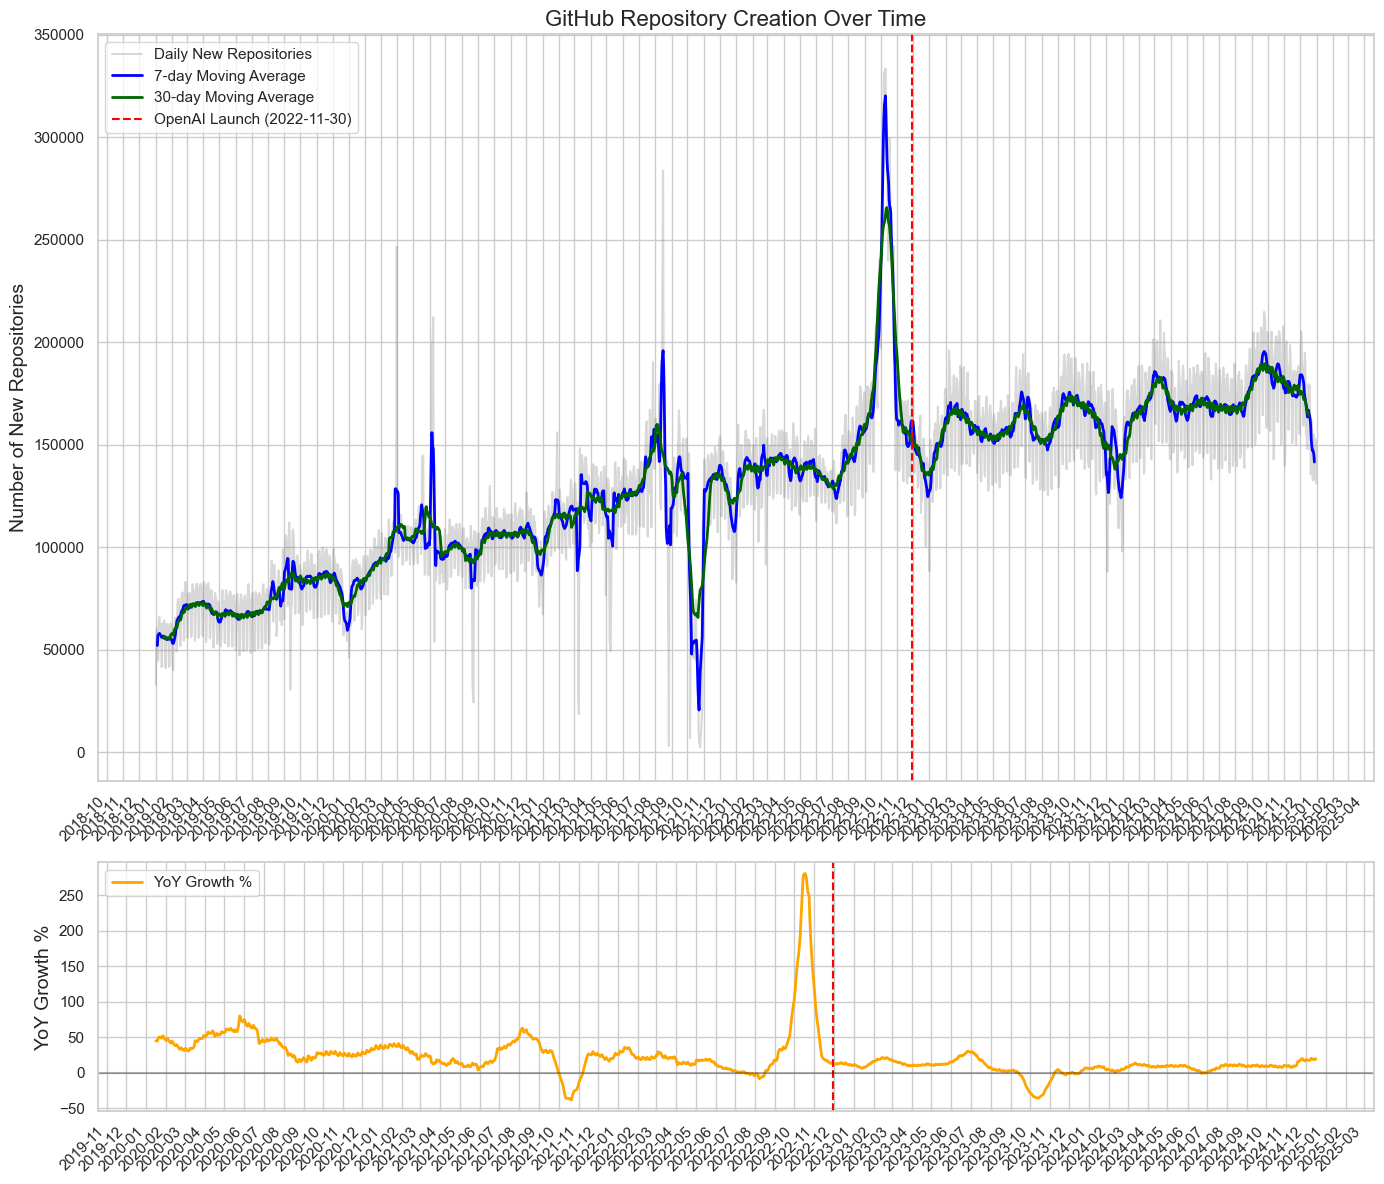


===== Statistical Analysis =====
Time periods analyzed: 763 days before and after OpenAI launch
Average daily new repositories before launch: 134361.48
Average daily new repositories after launch: 164233.70
Percent change: 22.23%
t-statistic: -18.2782
p-value: 0.0000
The change is statistically significant at the 5% level

===== Interrupted Time Series Analysis =====
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5.836e+04   1333.319     43.771      0.000    5.57e+04     6.1e+04
time            74.6916      1.627     45.902      0.000      71.501      77.883
intervention  4.253e+04   7613.481      5.586      0.000    2.76e+04    5.75e+04
time_after     -39.5205      4.440     -8.901      0.000     -48.228     -30.813

Interpretation:
There was an immediate INCREASE of 42529.38 repositories after the OpenAI launch (p=0.0000)
The SLOPE of repository creation D

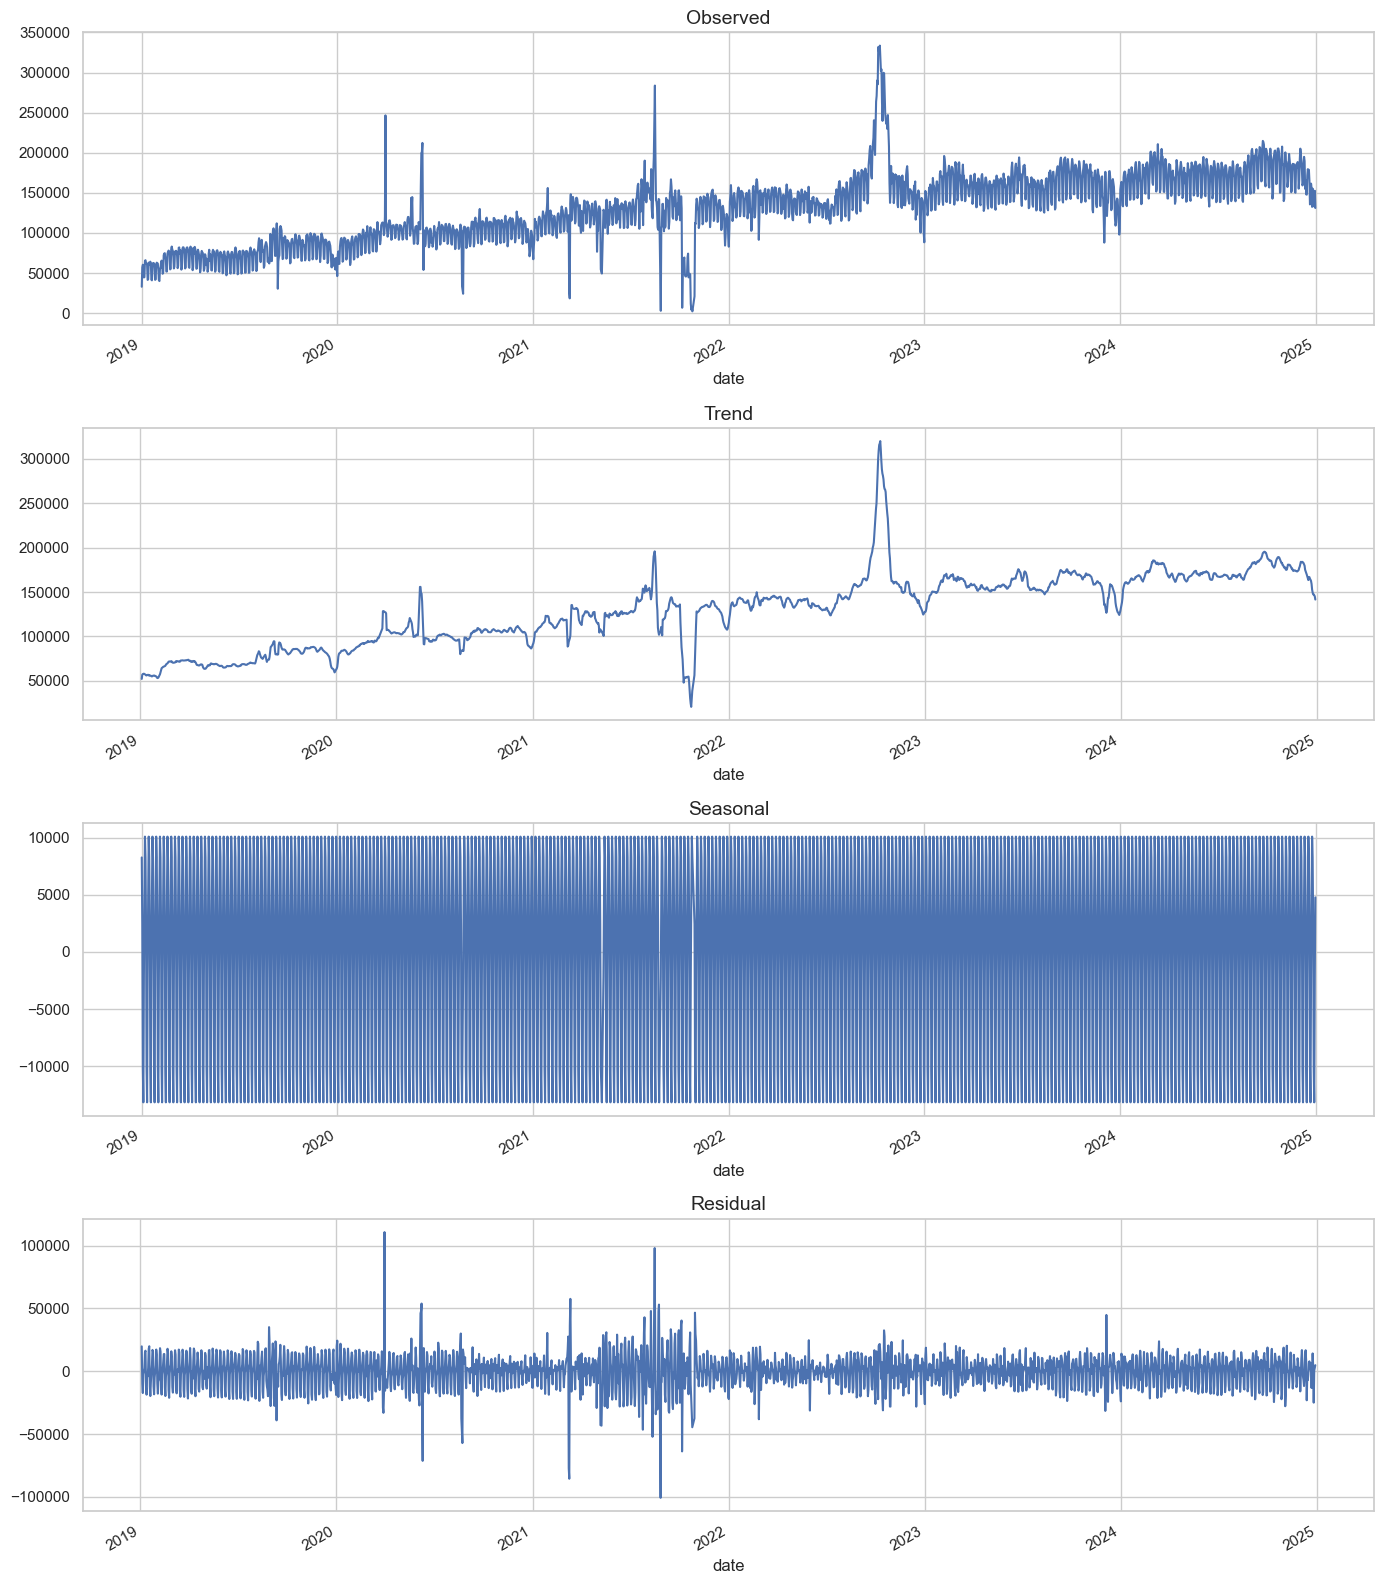

In [3]:
file_path = "bq-results-2.csv"  # Update this to your actual file path
openai_launch_date = "2022-11-30"
df = load_data(file_path)
print(f"Loaded data with {len(df)} rows from {df['date'].min()} to {df['date'].max()}")
df = preprocess_data(df, openai_launch_date)
plot_trends(df, openai_launch_date, save_path="github_repo_trends.png")
perform_statistical_analysis(df, openai_launch_date)
decomposition = decompose_time_series(df)

Loading data...
Data loaded: 2183 days from 2019-01-01 00:00:00 to 2024-12-31 00:00:00
Splitting data at OpenAI launch date: 2022-11-30
Pre-launch period: 1420 days
Post-launch period: 763 days
Fitting SARIMA model...
Model fitting complete
Generating forecast for 763 days after launch...

===== Impact Metrics =====
Total actual repositories: 125,310,312
Total predicted repositories: 12,853,378.646497488
Total difference: 112,456,933.35350251 repositories
Total percentage difference: 874.92%
Average daily difference: 147387.85 repositories
Average daily percentage difference: -332.03%
Days outside 95% confidence interval: 0 (0.00%)

Analysis complete! Results saved to CSV files.


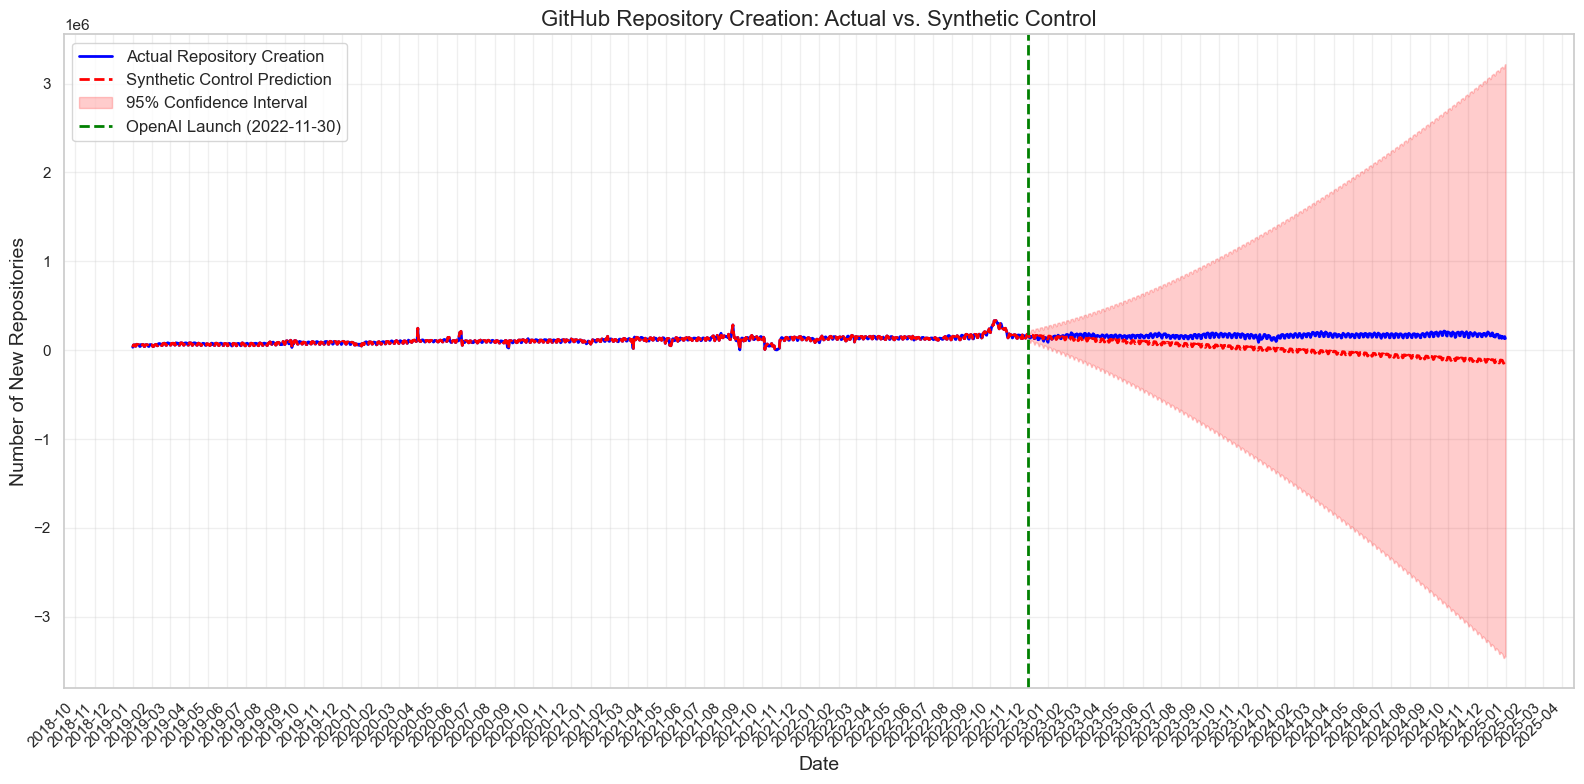

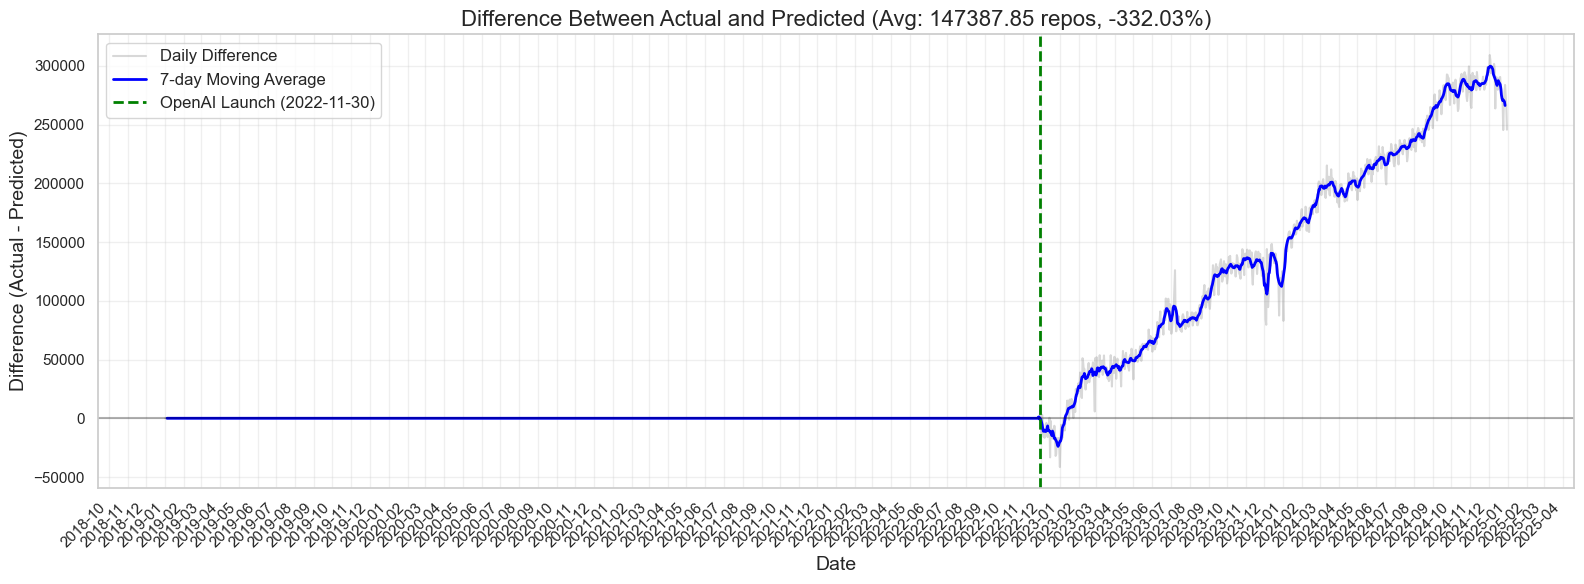

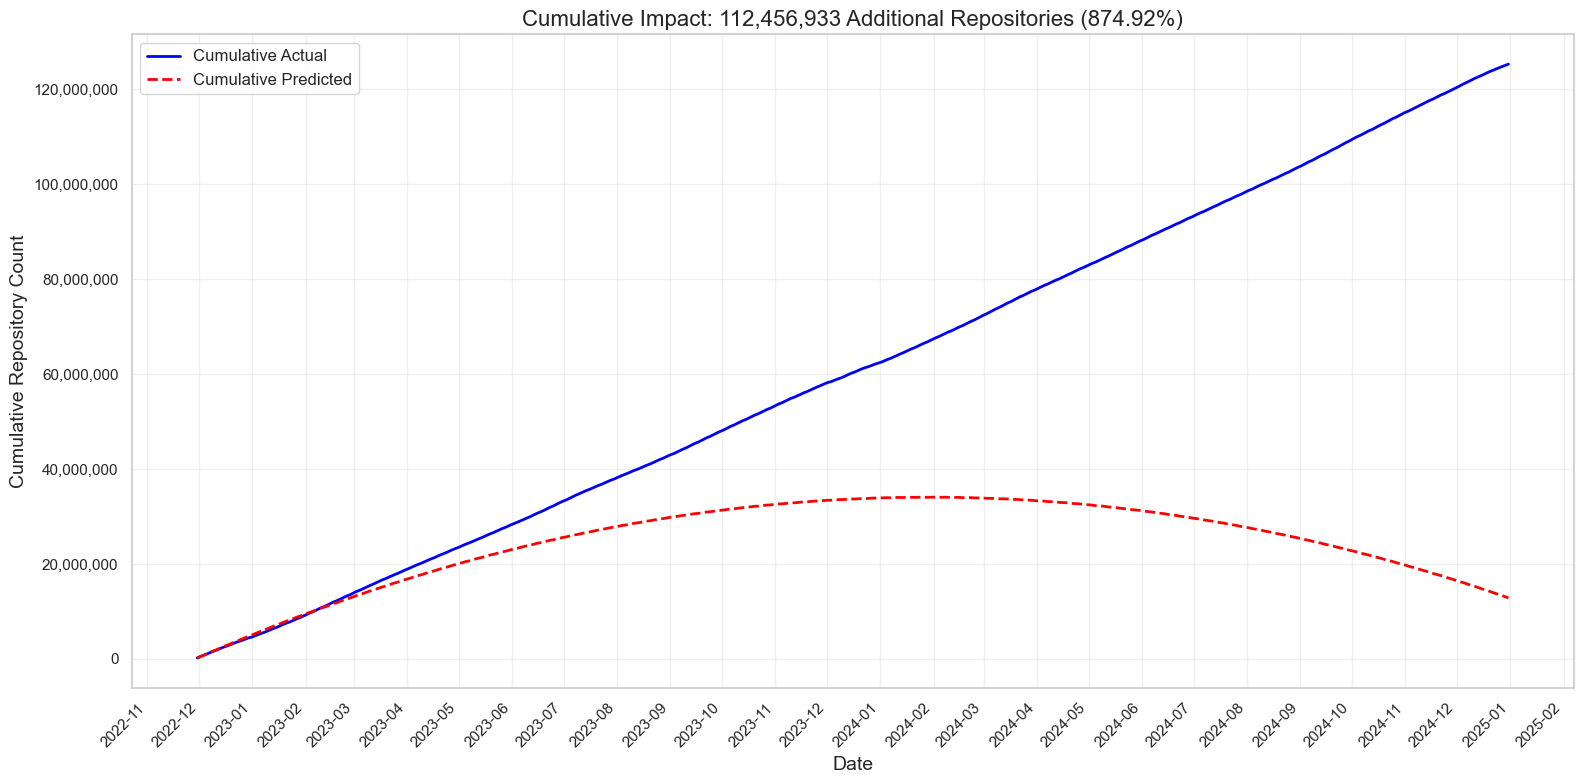

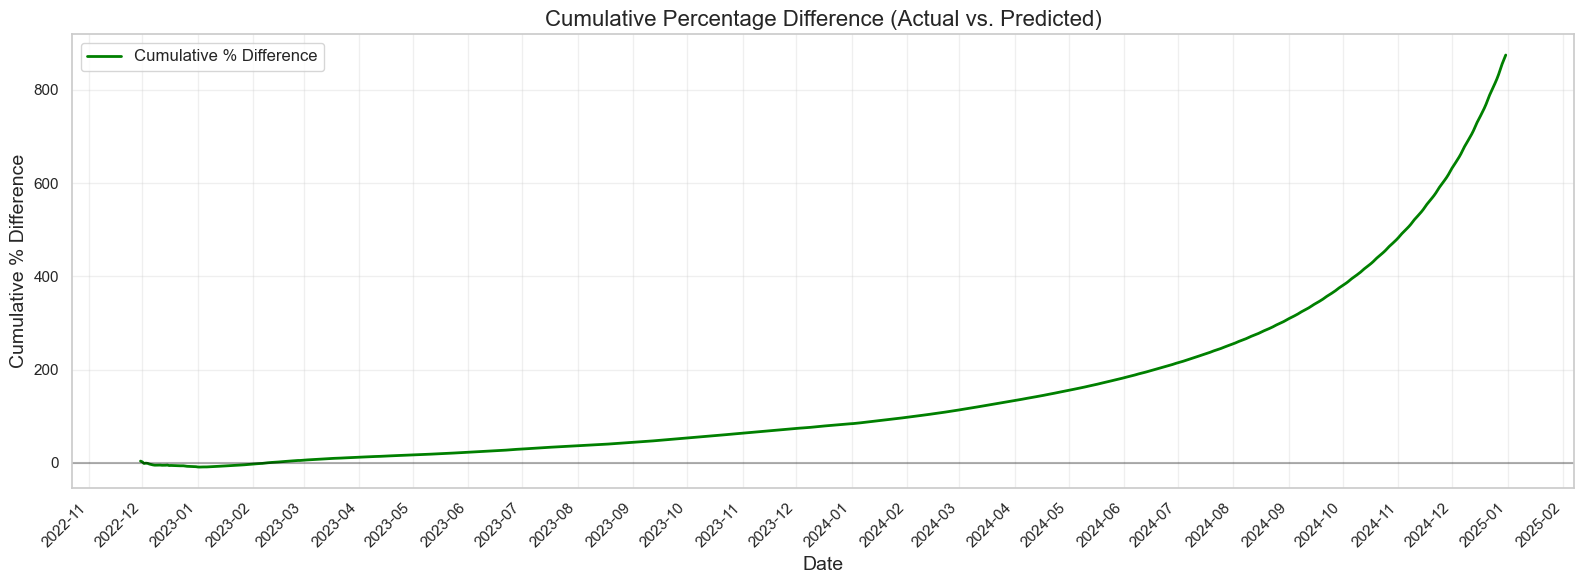

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Define the OpenAI launch date (ChatGPT public release)
openai_launch_date = "2022-11-30"

# Load data
def load_data(file_path):
    """
    Load the GitHub repository data from CSV
    """
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    return df

# Create a function to split data into pre and post launch periods
def split_data(df, launch_date):
    """
    Split the data into pre and post launch periods
    """
    df['post_launch'] = (df['date'] >= launch_date).astype(int)
    pre_launch = df[df['date'] < launch_date]
    post_launch = df[df['date'] >= launch_date]
    return pre_launch, post_launch

# Build a SARIMA model for forecasting
def build_sarima_model(pre_launch_df):
    """
    Build and train a SARIMA model on pre-launch data
    """
    # Set date as index for time series modeling
    ts_data = pre_launch_df.set_index('date')['new_repos']
    
    # Determine model parameters (use auto_arima or set manually)
    # For this example, we'll use parameters that typically work well with daily data
    # p,d,q for ARIMA and P,D,Q,s for seasonal component
    # For daily data with weekly seasonality, s=7 is common
    p, d, q = 1, 1, 1
    P, D, Q, s = 1, 1, 1, 7
    
    # Build the model
    model = SARIMAX(
        ts_data,
        order=(p, d, q),
        seasonal_order=(P, D, Q, s),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    # Fit the model
    print("Fitting SARIMA model...")
    model_fit = model.fit(disp=False)
    print("Model fitting complete")
    
    return model_fit

# Generate counterfactual predictions
def generate_counterfactual(model_fit, full_df, pre_launch_df, post_launch_df):
    """
    Generate counterfactual predictions for the post-launch period
    """
    # Number of steps to forecast
    steps = len(post_launch_df)
    
    # Create forecast
    print(f"Generating forecast for {steps} days after launch...")
    forecast = model_fit.get_forecast(steps=steps)
    forecast_mean = forecast.predicted_mean
    
    # Get confidence intervals
    confidence_intervals = forecast.conf_int()
    lower_bound = confidence_intervals.iloc[:, 0]
    upper_bound = confidence_intervals.iloc[:, 1]
    
    # Create forecast DataFrame
    forecast_df = pd.DataFrame({
        'date': post_launch_df['date'].values,
        'predicted_repos': forecast_mean.values,
        'lower_ci': lower_bound.values,
        'upper_ci': upper_bound.values,
        'actual_repos': post_launch_df['new_repos'].values
    })
    
    # Calculate difference between actual and predicted
    forecast_df['diff'] = forecast_df['actual_repos'] - forecast_df['predicted_repos']
    forecast_df['percent_diff'] = (forecast_df['diff'] / forecast_df['predicted_repos']) * 100
    
    # Combine with the pre-launch data for plotting
    pre_forecast_df = pd.DataFrame({
        'date': pre_launch_df['date'].values,
        'predicted_repos': pre_launch_df['new_repos'].values,  # Use actual as predicted for pre-launch
        'lower_ci': pre_launch_df['new_repos'].values,
        'upper_ci': pre_launch_df['new_repos'].values,
        'actual_repos': pre_launch_df['new_repos'].values,
        'diff': np.zeros(len(pre_launch_df)),  # Zero difference for pre-launch period
        'percent_diff': np.zeros(len(pre_launch_df))  # Zero percent diff for pre-launch period
    })
    
    full_forecast_df = pd.concat([pre_forecast_df, forecast_df], ignore_index=True)
    full_forecast_df = full_forecast_df.sort_values('date')
    
    return full_forecast_df

# Calculate impact metrics
def calculate_impact(forecast_df, openai_launch_date):
    """
    Calculate the impact of OpenAI launch on repository creation
    """
    # Filter to post-launch period
    post_launch_forecast = forecast_df[forecast_df['date'] >= openai_launch_date]
    
    # Calculate differences between actual and predicted
    # These calculations are now handled in the generate_counterfactual function
    
    # Calculate cumulative impact
    total_actual = post_launch_forecast['actual_repos'].sum()
    total_predicted = post_launch_forecast['predicted_repos'].sum()
    total_diff = total_actual - total_predicted
    total_percent = (total_diff / total_predicted) * 100
    
    # Calculate average daily impact
    avg_diff = post_launch_forecast['diff'].mean()
    avg_percent = post_launch_forecast['percent_diff'].mean()
    
    # Calculate error metrics
    rmse = np.sqrt(mean_squared_error(post_launch_forecast['actual_repos'], post_launch_forecast['predicted_repos']))
    mae = mean_absolute_error(post_launch_forecast['actual_repos'], post_launch_forecast['predicted_repos'])
    
    # Check if actual values are consistently outside the confidence interval
    outside_ci_count = sum(
        (post_launch_forecast['actual_repos'] > post_launch_forecast['upper_ci']) | 
        (post_launch_forecast['actual_repos'] < post_launch_forecast['lower_ci'])
    )
    outside_ci_percent = (outside_ci_count / len(post_launch_forecast)) * 100
    
    impact_metrics = {
        'total_actual': total_actual,
        'total_predicted': total_predicted,
        'total_diff': total_diff,
        'total_percent': total_percent,
        'avg_diff': avg_diff,
        'avg_percent': avg_percent,
        'rmse': rmse,
        'mae': mae,
        'outside_ci_count': outside_ci_count,
        'outside_ci_percent': outside_ci_percent
    }
    
    return impact_metrics, post_launch_forecast

# Plot the results
def plot_synthetic_control(forecast_df, openai_launch_date):
    """
    Plot the actual vs. counterfactual prediction
    """
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot actual data
    ax.plot(forecast_df['date'], forecast_df['actual_repos'], 
            label='Actual Repository Creation', color='blue', linewidth=2)
    
    # Plot predicted data
    ax.plot(forecast_df['date'], forecast_df['predicted_repos'], 
            label='Synthetic Control Prediction', color='red', linestyle='--', linewidth=2)
    
    # Plot confidence intervals
    ax.fill_between(forecast_df['date'], 
                   forecast_df['lower_ci'], 
                   forecast_df['upper_ci'], 
                   color='red', alpha=0.2, label='95% Confidence Interval')
    
    # Mark the OpenAI launch date
    launch_date = pd.to_datetime(openai_launch_date)
    ax.axvline(x=launch_date, color='green', linestyle='--', linewidth=2,
              label=f'OpenAI Launch ({launch_date.strftime("%Y-%m-%d")})')
    
    # Add labels and title
    ax.set_title('GitHub Repository Creation: Actual vs. Synthetic Control', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Number of New Repositories', fontsize=14)
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add legend
    ax.legend(loc='best', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Plot the difference between actual and predicted
def plot_difference(forecast_df, openai_launch_date, impact_metrics):
    """
    Plot the difference between actual and predicted values
    """
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Calculate rolling average of difference to smooth out daily fluctuations
    forecast_df['diff_ma7'] = forecast_df['diff'].rolling(window=7, center=True).mean()
    
    # Plot the difference
    ax.plot(forecast_df['date'], forecast_df['diff'], color='gray', alpha=0.3, label='Daily Difference')
    ax.plot(forecast_df['date'], forecast_df['diff_ma7'], color='blue', linewidth=2, label='7-day Moving Average')
    
    # Add a zero line
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Mark the OpenAI launch date
    launch_date = pd.to_datetime(openai_launch_date)
    ax.axvline(x=launch_date, color='green', linestyle='--', linewidth=2,
              label=f'OpenAI Launch ({launch_date.strftime("%Y-%m-%d")})')
    
    # Add labels and title
    avg_diff = impact_metrics['avg_diff']
    avg_percent = impact_metrics['avg_percent']
    ax.set_title(f'Difference Between Actual and Predicted (Avg: {avg_diff:.2f} repos, {avg_percent:.2f}%)', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Difference (Actual - Predicted)', fontsize=14)
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add legend
    ax.legend(loc='best', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Plot cumulative impact
def plot_cumulative_impact(forecast_df, openai_launch_date):
    """
    Plot the cumulative impact of OpenAI launch on repository creation
    """
    # Calculate cumulative values
    post_launch = forecast_df[forecast_df['date'] >= openai_launch_date].copy()
    post_launch['cum_actual'] = post_launch['actual_repos'].cumsum()
    post_launch['cum_predicted'] = post_launch['predicted_repos'].cumsum()
    post_launch['cum_diff'] = post_launch['cum_actual'] - post_launch['cum_predicted']
    post_launch['cum_percent'] = (post_launch['cum_diff'] / post_launch['cum_predicted']) * 100
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot cumulative actual and predicted
    ax.plot(post_launch['date'], post_launch['cum_actual'], 
            label='Cumulative Actual', color='blue', linewidth=2)
    ax.plot(post_launch['date'], post_launch['cum_predicted'], 
            label='Cumulative Predicted', color='red', linestyle='--', linewidth=2)
    
    # Add labels and title
    final_diff = post_launch['cum_diff'].iloc[-1]
    final_percent = post_launch['cum_percent'].iloc[-1]
    ax.set_title(f'Cumulative Impact: {final_diff:,.0f} Additional Repositories ({final_percent:.2f}%)', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Cumulative Repository Count', fontsize=14)
    
    # Format y-axis with commas for thousands
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
    # Format x-axis dates
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add legend
    ax.legend(loc='best', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Create a second plot for cumulative percentage difference
    fig2, ax2 = plt.subplots(figsize=(16, 6))
    
    ax2.plot(post_launch['date'], post_launch['cum_percent'], 
            label='Cumulative % Difference', color='green', linewidth=2)
    
    # Add a zero line
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add labels and title
    ax2.set_title('Cumulative Percentage Difference (Actual vs. Predicted)', fontsize=16)
    ax2.set_xlabel('Date', fontsize=14)
    ax2.set_ylabel('Cumulative % Difference', fontsize=14)
    
    # Format x-axis dates
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add legend
    ax2.legend(loc='best', fontsize=12)
    
    # Add grid
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return fig, fig2, post_launch

# Main function to run the synthetic control analysis
def run_synthetic_control_analysis(file_path):
    """
    Run the synthetic control analysis on GitHub repository data
    """
    print("Loading data...")
    df = load_data(file_path)
    print(f"Data loaded: {len(df)} days from {df['date'].min()} to {df['date'].max()}")
    
    # Check if the required columns exist
    required_columns = ['date', 'new_repos']
    for col in required_columns:
        if col not in df.columns:
            print(f"Error: Column '{col}' not found in the data")
            # Check if there are similar column names that might be used instead
            similar_cols = [c for c in df.columns if col.lower() in c.lower()]
            if similar_cols:
                print(f"Found similar columns: {similar_cols}")
                # If we find a likely match for 'new_repos', use it
                if col == 'new_repos' and len(similar_cols) == 1:
                    print(f"Using '{similar_cols[0]}' as '{col}'")
                    df[col] = df[similar_cols[0]]
                else:
                    return None, None, None
            else:
                return None, None, None
    
    # Split data into pre and post launch periods
    print(f"Splitting data at OpenAI launch date: {openai_launch_date}")
    pre_launch, post_launch = split_data(df, openai_launch_date)
    print(f"Pre-launch period: {len(pre_launch)} days")
    print(f"Post-launch period: {len(post_launch)} days")
    
    # Build the SARIMA model on pre-launch data
    model_fit = build_sarima_model(pre_launch)
    
    # Generate counterfactual predictions
    forecast_df = generate_counterfactual(model_fit, df, pre_launch, post_launch)
    
    # Calculate impact metrics
    impact_metrics, post_forecast = calculate_impact(forecast_df, openai_launch_date)
    
    # Display impact metrics
    print("\n===== Impact Metrics =====")
    print(f"Total actual repositories: {impact_metrics['total_actual']:,}")
    print(f"Total predicted repositories: {impact_metrics['total_predicted']:,}")
    print(f"Total difference: {impact_metrics['total_diff']:,} repositories")
    print(f"Total percentage difference: {impact_metrics['total_percent']:.2f}%")
    print(f"Average daily difference: {impact_metrics['avg_diff']:.2f} repositories")
    print(f"Average daily percentage difference: {impact_metrics['avg_percent']:.2f}%")
    print(f"Days outside 95% confidence interval: {impact_metrics['outside_ci_count']} ({impact_metrics['outside_ci_percent']:.2f}%)")
    
    # Plot the results
    fig1 = plot_synthetic_control(forecast_df, openai_launch_date)
    fig2 = plot_difference(forecast_df, openai_launch_date, impact_metrics)
    fig3, fig4, cum_data = plot_cumulative_impact(forecast_df, openai_launch_date)
    
    # Save the results
    forecast_df.to_csv('synthetic_control_forecast.csv', index=False)
    cum_data.to_csv('cumulative_impact.csv', index=False)
    
    print("\nAnalysis complete! Results saved to CSV files.")
    
    return forecast_df, impact_metrics, (fig1, fig2, fig3, fig4)

# Run the analysis
if __name__ == "__main__":
    file_path = "bq-results.csv"  # Update this to your actual file path
    forecast_df, impact_metrics, figures = run_synthetic_control_analysis(file_path)